In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegressionCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score


# Modélisation conditionnelle des décisions de politique monétaire

## 1. Introduction

L’objectif de ce projet est de **modéliser la dynamique des décisions de la Réserve Fédérale (Fed)** à partir de variables macroéconomiques et de signaux textuels.  
L’idée est de relier l’état de l’économie avant chaque meeting (inflation, chômage, courbe des taux, volatilité des marchés) et le ton du communiqué FOMC à la **probabilité d’une hausse future du taux directeur**.

Le modèle repose sur une **chaîne de Markov conditionnelle**, où la décision de politique monétaire dépend à la fois :
- de l’état précédent de la Fed (hausse ou statu quo/baisse),
- et des conditions macro-financières observées avant le meeting.

Cette approche permet d’estimer :
$$
\mathbb{P}(S_{t+1} = 1 \mid S_t, X_t)
$$
et d’analyser la **persistance des cycles hawkish/dovish** de la Fed ainsi que la sensibilité de ses décisions aux signaux économiques.

---

## 2. Dataset 1 : Meeting-Based (Markov Conditionnel)

### 2.1. Structure temporelle

Chaque observation correspond à un **meeting FOMC**.  
Les variables macroéconomiques \( X_t \) sont observées à **J−1** (veille du meeting) et représentent l’état de l’économie immédiatement avant la décision.  
Le score de sentiment est dérivé du communiqué publié à la date du meeting \( t \), donc post-décision mais antérieur au meeting suivant.

$$
X_t = [\, \text{macro}_t, \text{sentiment}_t \,]
$$

La cible du modèle est le **signe de la variation du taux directeur** entre deux meetings successifs :

$$
S_{t+1} = \text{sign}(DFF_{t+1} - DFF_t)
$$

et l’état courant est :

$$
S_t = \text{sign}(DFF_t - DFF_{t-1})
$$

Le modèle conditionnel estime donc :

$$
\mathbb{P}(S_{t+1} = 1 \mid S_t, X_t)
$$

---

### 2.2. Composition des variables


- **Variables macroéconomiques :**  
  $$ VIX_t,\; UNRATE_t,\; CPI_t,\; T10Y2Y_t $$

- **Variable textuelle :**  
  Score *FinBERT* de tonalité du communiqué FOMC  
  $$ \text{sentiment}_t $$

- **État courant :**  
  $$ S_t \in \{-1,\; +1\} $$

- **Cible :**  
  $$ S_{t+1} $$


---

### 2.3. Logique de construction

1. Extraction des **dates de meetings** et des **taux directeurs** (`DFF`).  
2. Jointure avec les **indicateurs macroéconomiques** à la date la plus proche avant le meeting (J−1).  
3. Fusion avec les **scores textuels** et les **10 composantes SVD** issues du pipeline NLP.  
4. Calcul des **états** \( S_t \) et \( S_{t+1} \).

Le dataset final, `MEETING_WITH_TEXT_MACRO.csv`, contient donc **une observation par meeting**  
et permet d’estimer une **chaîne de Markov conditionnelle** :

$$
\mathbb{P}(S_{t+1} = 1 \mid S_t, X_t)
= \sigma(\beta_0 + \beta_S S_t + \beta^\top X_t)
$$



In [30]:
df = pd.read_csv("./data/processed/MEETING_WITH_TEXT_MACRO.csv")
df["observation_date"] = pd.to_datetime(df["observation_date"])
df = df.sort_values("observation_date").reset_index(drop=True)


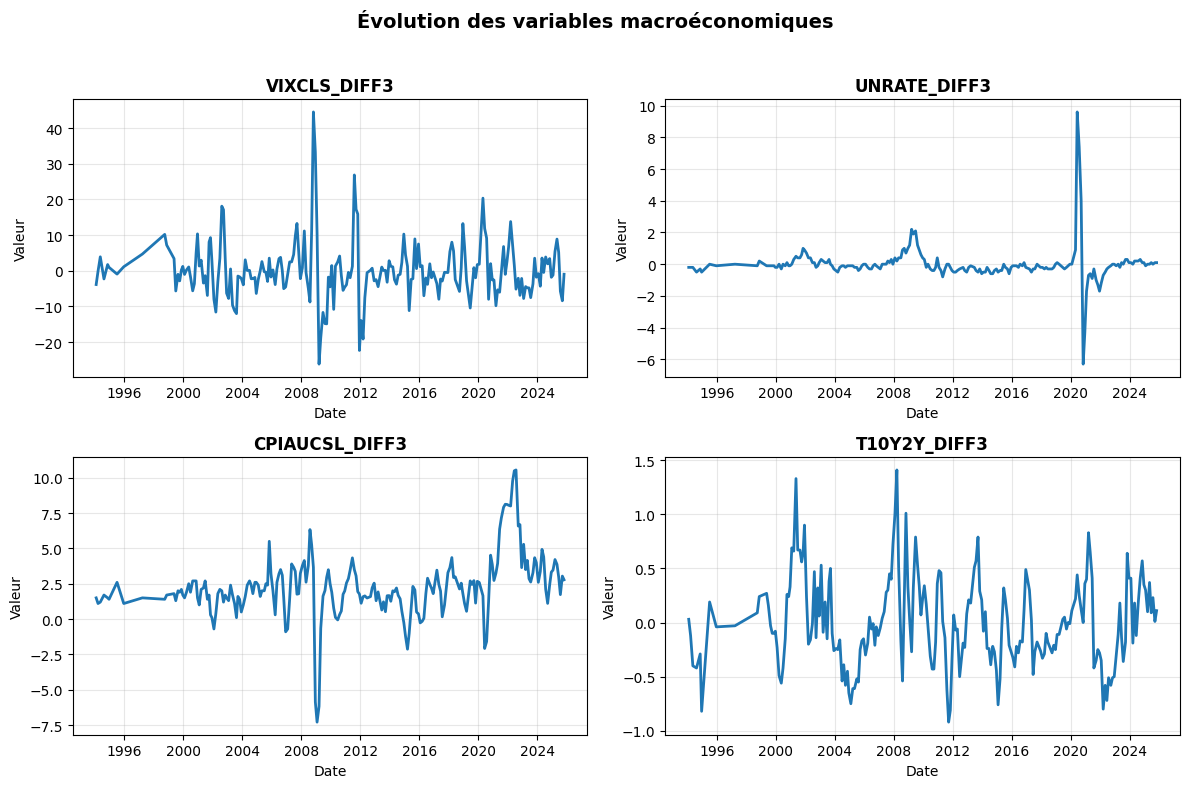

In [31]:
def plot_series_grid(df, var_names):
    if len(var_names) != 4:
        print("Il faut exactement 4 variables pour un affichage 2x2.")
        return

    missing = [v for v in var_names if v not in df.columns]
    if missing:
        print(f"Variables manquantes : {missing}")
        return

    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    axes = axes.flatten()

    for i, var in enumerate(var_names):
        ax = axes[i]
        ax.plot(df["observation_date"], df[var], lw=2, color="tab:blue")
        ax.set_title(var, fontsize=12, weight="bold")
        ax.grid(alpha=0.3)
        ax.set_xlabel("Date")
        ax.set_ylabel("Valeur")

    plt.suptitle("Évolution des variables macroéconomiques", fontsize=14, weight="bold")
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

# Exemple :
plot_series_grid(df, ["VIXCLS_DIFF3", "UNRATE_DIFF3", "CPIAUCSL_DIFF3", "T10Y2Y_DIFF3"])


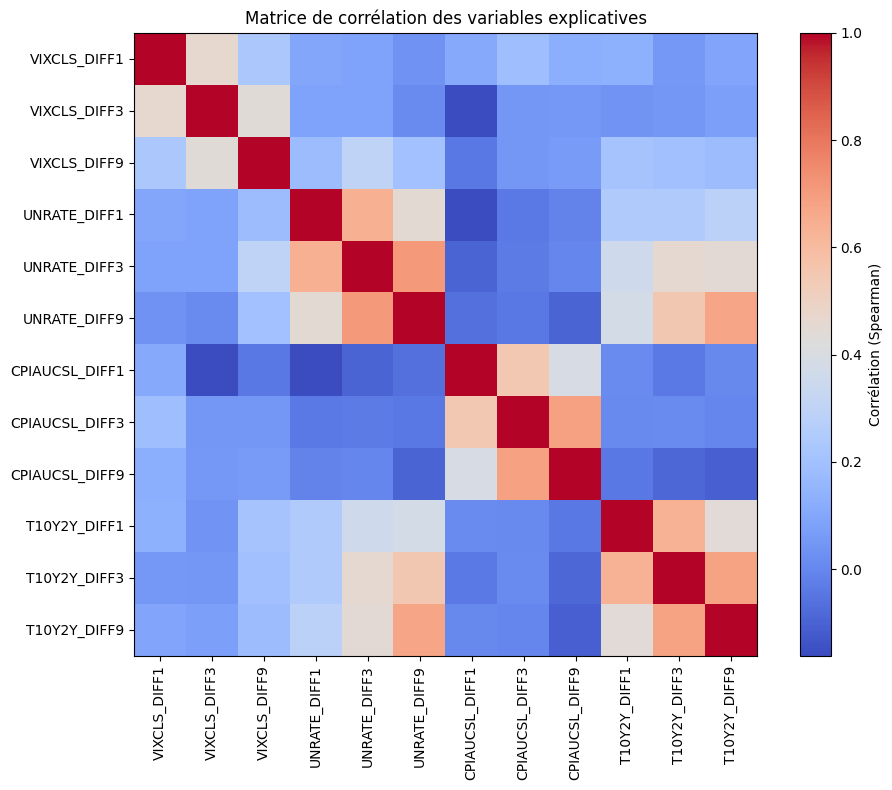


=== PAIRES DE VARIABLES LES PLUS CORRÉLÉES ===
UNRATE_DIFF9    UNRATE_DIFF3      0.705589
UNRATE_DIFF3    UNRATE_DIFF9      0.705589
CPIAUCSL_DIFF9  CPIAUCSL_DIFF3    0.683298
CPIAUCSL_DIFF3  CPIAUCSL_DIFF9    0.683298
T10Y2Y_DIFF9    T10Y2Y_DIFF3      0.679713
T10Y2Y_DIFF3    T10Y2Y_DIFF9      0.679713
T10Y2Y_DIFF9    UNRATE_DIFF9      0.671450
UNRATE_DIFF9    T10Y2Y_DIFF9      0.671450
UNRATE_DIFF1    UNRATE_DIFF3      0.640451
UNRATE_DIFF3    UNRATE_DIFF1      0.640451
dtype: float64


In [32]:
def analyze_correlations(df, macro_vars):
    features = [c for c in df.columns if any(v in c for v in macro_vars)
                and ("DIFF" in c or "MA" in c or "MOM" in c)]
    corr = df[features].corr(method='spearman')

    plt.figure(figsize=(10, 8))
    plt.imshow(corr, cmap='coolwarm', interpolation='nearest')
    plt.colorbar(label='Corrélation (Spearman)')
    plt.xticks(range(len(features)), features, rotation=90)
    plt.yticks(range(len(features)), features)
    plt.title("Matrice de corrélation des variables explicatives")
    plt.tight_layout()
    plt.show()

    corr_pairs = (
        corr.where(~np.eye(corr.shape[0], dtype=bool))
        .stack()
        .sort_values(ascending=False)
    )
    print("\n=== PAIRES DE VARIABLES LES PLUS CORRÉLÉES ===")
    print(corr_pairs.head(10))
    return features

macro_vars = ["VIXCLS", "UNRATE", "CPIAUCSL", "T10Y2Y"]
features = analyze_correlations(df, macro_vars)


In [24]:
def build_dataset_markov_order1(df):
    df = df.sort_values("observation_date").reset_index(drop=True)
    df["state_t"] = np.sign(df["DFF"].diff())
    df["state_t"] = df["state_t"].replace(0, np.nan).ffill()
    df["state_t1"] = np.sign(df["DFF"].shift(-1) - df["DFF"])
    df["state_t1"] = df["state_t1"].replace(0, -1)
    df = df.dropna(subset=["state_t", "state_t1"]).reset_index(drop=True)
    return df

df = build_dataset_markov_order1(df)


In [25]:
def fit_conditional_logit_order1(df, features, n_splits=5):
    X = df[features + ["state_t"]].copy()
    y = (df["state_t1"] == 1).astype(int)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    tscv = TimeSeriesSplit(n_splits=n_splits)
    oof_true, oof_pred, oof_prob = np.zeros(len(df)), np.zeros(len(df)), np.zeros(len(df))

    for fold, (train_idx, test_idx) in enumerate(tscv.split(X_scaled), 1):
        X_train, X_test = X_scaled[train_idx], X_scaled[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        model = LogisticRegressionCV(
            Cs=5, cv=3, penalty="elasticnet", solver="saga",
            l1_ratios=[0.2], class_weight="balanced", max_iter=10000, random_state=42
        )
        model.fit(X_train, y_train)
        y_prob = model.predict_proba(X_test)[:, 1]
        y_pred = (y_prob >= 0.5).astype(int)

        oof_true[test_idx] = y_test
        oof_pred[test_idx] = y_pred
        oof_prob[test_idx] = y_prob
        print(f"Fold {fold}: Accuracy = {accuracy_score(y_test, y_pred):.3f}")

    auc = roc_auc_score(oof_true, oof_prob)
    print("\n=== ÉVALUATION GLOBALE ===")
    print(confusion_matrix(oof_true, oof_pred))
    print(classification_report(oof_true, oof_pred, digits=3))
    print(f"AUC (globale) : {auc:.3f}")

    model_final = LogisticRegressionCV(
        Cs=5, cv=3, penalty="elasticnet", solver="saga",
        l1_ratios=[0.2], class_weight="balanced", max_iter=10000, random_state=42
    )
    model_final.fit(X_scaled, y)
    return model_final, scaler, oof_prob

model, scaler, y_prob = fit_conditional_logit_order1(df, features)


Fold 1: Accuracy = 0.675
Fold 2: Accuracy = 0.675
Fold 3: Accuracy = 0.475
Fold 4: Accuracy = 0.500
Fold 5: Accuracy = 0.750

=== ÉVALUATION GLOBALE ===
[[103  58]
 [ 19  60]]
              precision    recall  f1-score   support

         0.0      0.844     0.640     0.728       161
         1.0      0.508     0.759     0.609        79

    accuracy                          0.679       240
   macro avg      0.676     0.700     0.669       240
weighted avg      0.734     0.679     0.689       240

AUC (globale) : 0.775


In [26]:
def build_transition_matrix_order1(df, model, scaler, features):
    X_scaled = scaler.transform(df[features + ["state_t"]])
    df["prob_up"] = model.predict_proba(X_scaled)[:, 1]
    states = [-1, 1]
    M = {}
    for s in states:
        subset = df[df["state_t"] == s]
        if subset.empty:
            continue
        p_up = np.clip(subset["prob_up"].mean(), 0.0, 1.0)
        M[s] = np.array([[1 - p_up, p_up],
                         [1 - p_up, p_up]])

    print("\n=== MATRICE DE TRANSITION CONDITIONNELLE (ordre 1) ===")
    for s in M:
        print(f"\nÉtat courant {s}:")
        print(pd.DataFrame(M[s],
              columns=["→ -1 (baisse/statu quo)", "→ +1 (hausse)"],
              index=["-1 (baisse/statu quo)", "+1 (hausse)"]))
    return M

M = build_transition_matrix_order1(df, model, scaler, features)



=== MATRICE DE TRANSITION CONDITIONNELLE (ordre 1) ===

État courant -1:
                       → -1 (baisse/statu quo)  → +1 (hausse)
-1 (baisse/statu quo)                 0.547591       0.452409
+1 (hausse)                           0.547591       0.452409

État courant 1:
                       → -1 (baisse/statu quo)  → +1 (hausse)
-1 (baisse/statu quo)                 0.474924       0.525076
+1 (hausse)                           0.474924       0.525076


In [27]:
def simulate_markov_order1(M, init_state=1, n_steps=50, seed=42):
    np.random.seed(seed)
    states = [-1, 1]
    s = init_state
    seq = [s]
    for _ in range(n_steps):
        if s not in M:
            s = np.random.choice(states)
        p_up = M[s][0, 1]
        p_up = np.clip(p_up, 0.0, 1.0)
        s = np.random.choice(states, p=[1 - p_up, p_up])
        seq.append(s)
    return np.array(seq)


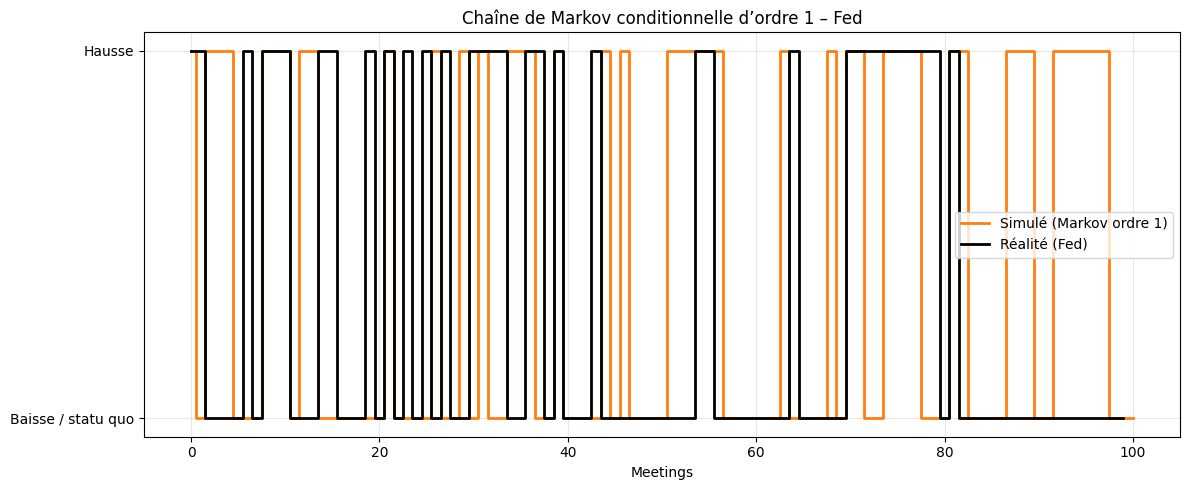


=== DURÉE MOYENNE DES CYCLES (en meetings) ===
Régime -1 : Réel = 2.06 | Simulé = 2.20
Régime +1 : Réel = 3.82 | Simulé = 2.85


In [28]:
def mean_run_length(seq, state):
    seq = np.array(seq)
    runs = np.diff(np.where(np.concatenate(([seq[0] != state],
                                           seq[:-1] != seq[1:],
                                           [True])))[0])[::2]
    return runs.mean() if len(runs) else np.nan


def compare_simulated_vs_real(df, M, n_steps=50, init_state=1):
    real_seq = df["state_t1"].values[-n_steps:]
    sim_seq = simulate_markov_order1(M, init_state=init_state, n_steps=n_steps)

    plt.figure(figsize=(12,5))
    plt.step(range(len(sim_seq)), sim_seq, where="mid", lw=2, color="tab:orange", label="Simulé (Markov ordre 1)")
    plt.step(range(len(real_seq)), real_seq, where="mid", lw=2, color="black", label="Réalité (Fed)")
    plt.yticks([-1, 1], ["Baisse / statu quo", "Hausse"])
    plt.xlabel("Meetings")
    plt.title("Chaîne de Markov conditionnelle d’ordre 1 – Fed")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    print("\n=== DURÉE MOYENNE DES CYCLES (en meetings) ===")
    for s in [-1, 1]:
        real_dur = mean_run_length(real_seq, s)
        sim_dur = mean_run_length(sim_seq, s)
        print(f"Régime {s:+d} : Réel = {real_dur:.2f} | Simulé = {sim_dur:.2f}")

compare_simulated_vs_real(df, M, n_steps=100, init_state=1)
